In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import spacy
nlp = spacy.load('en_core_web_lg')

vectors generated by Spacy gained from pre-trained GloVe model

<center><h1>N-grams with Word embeddings</h1></center>

How can we incorporate N-Grams features with our word embedding, we use **convolution**.

The window size indicate the N in N-gram, like for example if the kernel size is `3x300`, this means 3-grams model and so on 

In [2]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
stop=nltk.corpus.stopwords.words('english')

In [3]:
# creat tag map between treebank and wordnet
# tree bank : collection of syntactically annotated sentences
tag_map = {
"CC": None, #formatted. conjunction (and, but, or)
'CD': wn.NOUN, # original number (one,two)
'DT': None, # delimiter (a, the)
'EX': wn.ADV, #and my "there" (there)
"FW": None, # foreign word (mea culpa)
"IN": wn.ADV,# preposition/subjunctive conjunction (of, in,by) 
'JJ': [wn.ADJ, wn.ADJ_SAT],# adjective # (yellow)
'JJR': [wn.ADJ, wn.ADJ_SAT], # add, comparator (larger)
"JJS": [wn.ADJ, wn.ADJ_SAT], # add, superlative (wildest)
"LS": None, #list item tag(1,2,One)
'MD': None, # modal (can, should)
'NN': wn.NOUN, #noun, sing. or nugget (llama)
'NNS': wn.NOUN, #noun, plural (Llamas)
"NNP": wn.NOUN, # proper noun, vocals. (IBM)
'NNPS': wn.NOUN, # proper noun, plural (Carolina)
"PDT": [wn.ADJ, wn.ADJ_SAT], # predeterminer (all, both)
'POS':None, # end of ownership
'PRP': None, # personal pronoun (I, you, he)
'prp$': None, # possessive pronoun (your, one's)
"RB": wn.ADV, #adv (quickly, never)
'RBR': wn.ADV, # adverb, comparative (faster)
'RBS':wn.ADV,# adverb, superlative (fastest)
'RP': [wn.ADJ, wn.ADJ_SAT], # particle (up, off)
'SYM': None, #symbol, # (+, %, &)
'TO': None, # 'to' (to)
'UH': None, # interjection (uh, oops)
'VB': wn.VERB,# verb base form # (eat)
'VBD': wn.VERB, # verb past tense (eat)
'VBG': wn.VERB, #verb gerund (to eat)
'VBN': wn.VERB, # past participle (eaten)
"VBP": wn.VERB, #non-3sg pres verb (eat)
'VBZ': wn.VERB,# verb зsg pres (egts) 
}

In [4]:
lemma=WordNetLemmatizer()
def get_lemma(text):
    l=[]
    tags=pos_tag(text.split())
    for token,tag in tags:
        try:
             l.append(lemma.lemmatize(token,pos=tag_map[tag][0]))
        except:
            continue
    return l

In [5]:
from termcolor import colored
def cleaning(df):
    """
    - remove empty strings
    - remove duplicates
    """
    # remove empty string
    blanks=[]
    for i ,v in df.itertuples():
        if v.isspace() ==True or v=='':
            blanks.append(i)
    if len(blanks)>0:
        df=df.drop(blanks)
        print(f"found {colored(len(blanks),'red')} blanks")
    else:
        print("no blanks found")

    # remove duplicates
    if df.duplicated().sum() !=0:
        print(f"dropped {colored(df.duplicated().sum(),'red')} : values")
        df=df.drop_duplicates()
    else:
        print("no duplicates found")
    return df

In [6]:
import re
import string
def preprocessing(df,col):
    # lowercasing
    df[col]=df[col].apply(lambda x: " ".join(t.lower() for t in x.split()))
    # remove emails
    df[col]=df[col].apply(lambda x: re.sub("\S+\@\S+",'',x))
    # remove URls
    df[col]=df[col].apply(lambda x: re.sub("\S+\.\S+",'',x))
    # remove punctations
    df[col]=df[col].apply(lambda x: re.sub(f'[{re.escape(string.punctuation)}]',' ',x))
    # remove stopwords
    df[col]=df[col].apply(lambda x :" ".join(t for t in x.lower().split() if t not in stop))
    # remove \n or \t
    df[col]=df[col].apply(lambda x: re.sub('\n|\t',' ',x))
    # remove 2 characters words
    df[col]=df[col].apply(lambda x: re.sub(r' \w\w ',' ',x) )
    # remove 1 character words
    df[col]=df[col].apply(lambda x: re.sub(r' \w ',' ',x) )
    # remove extra spaces more than or equals "2" 
    df[col]=df[col].apply(lambda x: re.sub(" {2,}",' ',x))
    # select alphapetical only
    df[col]=df[col].apply(lambda x: re.sub("[^a-z]+",' ',x) )
    # strip string
    df[col]=df[col].apply(lambda x: x.strip())
    # get lemma
    df[col]=df[col].apply(lambda x: " ".join(get_lemma(x)))
    return df

In [7]:
# remove empty strings  
# remove duplicates 
# remove 1 character words
# remove 2 characters words

In [8]:
df=pd.read_csv(r'smsspamcollection.tsv',sep='\t')

In [9]:
x=df['message']
y=df['label']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.33,random_state=42)

In [11]:
x_train=pd.DataFrame(X_train,columns=['message'])
x_test=pd.DataFrame(X_test,columns=['message'])

In [12]:
cleaned_train=cleaning(x_train)
cleaned_test=cleaning(x_test)

no blanks found
dropped 210 : values
no blanks found
dropped 65 : values


In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
prep_train=preprocessing(cleaned_train,col='message')
prep_test=preprocessing(cleaned_test,col='message')

In [15]:
y_train=y_train[prep_train.index]
y_test=y_test[prep_test.index]

In [16]:
# 

In [17]:
def get_longest_text(texts):
    longest=0
    for text in texts:
        text_len=len(text.split())
        longest=max(text_len,longest)
    return longest

In [18]:
longest_input=get_longest_text(prep_train['message'])
longest_input

66

In [19]:
# no of messages ,no of tokens ,vector
# message --> have 66 token -->each token has 300 vecto size
# 

In [20]:
train_emb=np.zeros((len(prep_train),longest_input,300))
test_emb=np.zeros((len(prep_test),longest_input,300))

In [21]:
train_emb[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(66, 300))

In [22]:
from tqdm.auto import tqdm
for i ,text in tqdm(enumerate(nlp.pipe(prep_train['message'])),total=(len(prep_train))):
    for j , token in enumerate(text):
        train_emb[i,j]=token.vector

  0%|          | 0/3523 [00:00<?, ?it/s]

In [23]:
from tqdm.auto import tqdm
for i ,text in tqdm(enumerate(nlp.pipe(prep_test['message'])),total=(len(prep_test))):
    for j , token in enumerate(text):
        test_emb[i,j]=token.vector

  0%|          | 0/1774 [00:00<?, ?it/s]

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Reshape,Conv2D,MaxPool2D,Flatten,Dense,concatenate
from tensorflow.keras.models import Model

In [25]:
inputs = Input((longest_input, 300))

In [26]:
inputs

<KerasTensor shape=(None, 66, 300), dtype=float32, sparse=False, ragged=False, name=keras_tensor>

In [45]:
reshaped=Reshape((longest_input, 300,1))(inputs)

In [46]:
reshaped

<KerasTensor shape=(None, 66, 300, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_5>

In [ ]:
filters = [2, 3, 4]
# ((n-f+2p)/s)+1
conv_1=Conv2D(100,(filters[0],300),activation='relu')(reshaped)#input(N,66,300,1)-->output(N,65,1,100) 
conv_2=Conv2D(100,(filters[1],300),activation='relu')(reshaped)
conv_3=Conv2D(100,(filters[2],300),activation='relu')(reshaped)

pool_1=MaxPool2D(pool_size=(longest_input-filters[0]+1,1),strides=1)(conv_1)#input(N,65,1,100) -->output(N,1,1,100)
pool_2=MaxPool2D(pool_size=(longest_input-filters[1]+1,1),strides=1)(conv_2)
pool_3=MaxPool2D(pool_size=(longest_input-filters[2]+1,1),strides=1)(conv_3)

merged=concatenate([pool_1,pool_2,pool_3],axis=1)

flatten=Flatten()(merged)

In [60]:
dense=Dense(100,activation='relu')(flatten)

In [130]:
outputs=Dense(1,activation='sigmoid')(dense)

In [131]:
model=Model(inputs=inputs,outputs=outputs)

In [132]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.binary_crossentropy,metrics=['acc'])

In [133]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 66, 300)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_1 (Reshape)           │ (None, 66, 300, 1)        │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 65, 1, 100)        │          60,100 │ reshape_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 1, 100)        │          90,100 │ reshape_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 63, 1, 100)        │         120,100 │ reshape_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 1, 1, 100)         │               0 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 1, 1, 100)         │               0 │ conv2d_4[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 1, 1, 100)         │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 3, 1, 100)         │               0 │ max_pooling2d[0][0],       │
│                               │                           │                 │ max_pooling2d_1[0][0],     │
│                               │                           │                 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 300)               │               0 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 100)               │          30,100 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 1)                 │             101 │ dense[0][0]                │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 300,501 (1.15 MB)

 Trainable params: 300,501 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

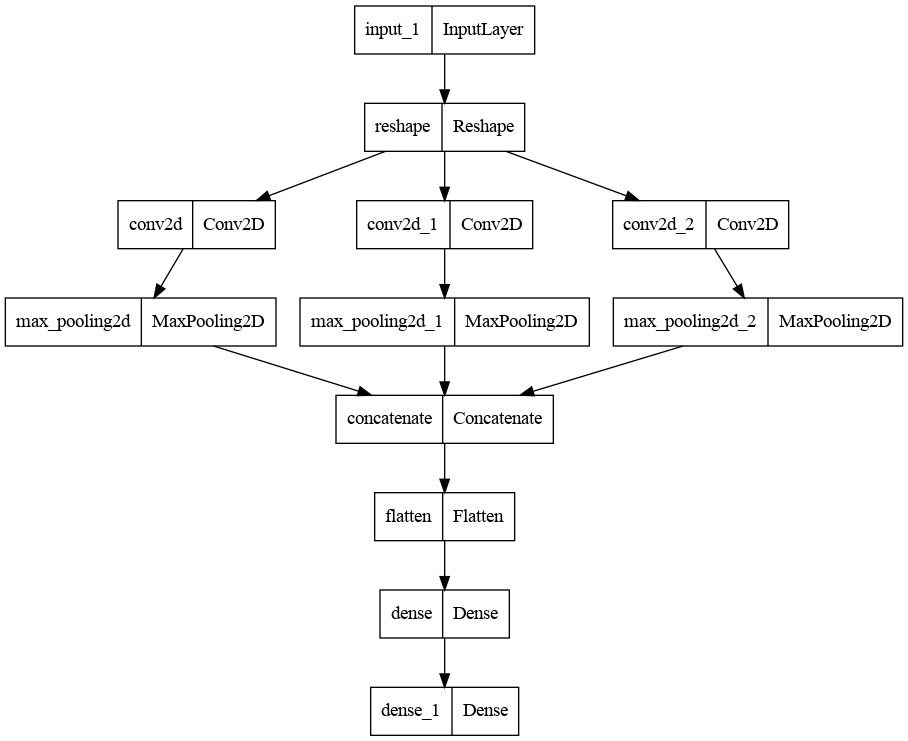

In [28]:
from sklearn.preprocessing import LabelEncoder

In [29]:
lb=LabelEncoder()
y_train=lb.fit_transform(y_train)
y_test=lb.transform(y_test)

In [134]:
history=model.fit(train_emb,y_train,epochs=5,batch_size=64,validation_split=0.2,verbose=1)

Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - acc: 0.9560 - loss: 0.1616 - val_acc: 0.9943 - val_loss: 0.0183
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - acc: 1.0000 - loss: 0.0043 - val_acc: 0.9957 - val_loss: 0.0138
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - acc: 1.0000 - loss: 0.0023 - val_acc: 0.9929 - val_loss: 0.0150
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - acc: 1.0000 - loss: 0.0013 - val_acc: 0.9929 - val_loss: 0.0143
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - acc: 1.0000 - loss: 9.0360e-04 - val_acc: 0.9929 - val_loss: 0.0145


In [135]:
training_accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

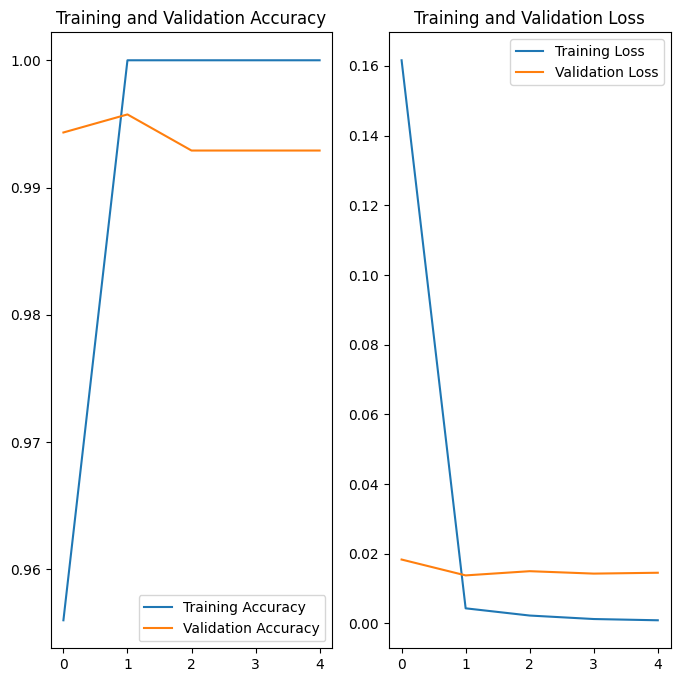

In [136]:
import matplotlib.pyplot as plt
epochs_range=range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [137]:
model.evaluate(test_emb, y_test)

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - acc: 0.9893 - loss: 0.0607


[0.06067131087183952, 0.9892897605895996]

In [138]:
prediction=model.predict(test_emb)

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


In [139]:
prediction

array([[6.8746235e-06],
       [2.8756904e-04],
       [4.4310173e-07],
       ...,
       [6.8683250e-05],
       [1.4882116e-04],
       [4.6481678e-04]], shape=(1774, 1), dtype=float32)

In [143]:
p=np.where(prediction>0.5,1,0)

In [147]:
print(classification_report(y_test, p))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1542
           1       0.99      0.93      0.96       232

    accuracy                           0.99      1774
   macro avg       0.99      0.96      0.98      1774
weighted avg       0.99      0.99      0.99      1774



In [151]:
lb.classes_

array(['ham', 'spam'], dtype=object)

In [163]:
def predict_n_gram(text):
    text_v = np.zeros((1, longest_input, 300))
    for i, token in enumerate(nlp(text)):
        if i>longest_input: #>= to work on long text
            break
        text_v[0, i] = token.vector
    # predict the input 
    prediction = model.predict(text_v)
    p=np.where(prediction>0.5,1,0)
    label = lb.classes_[p]
    return label

In [164]:
x=x_train.iloc[50].message

x=x+x+x+x+x+x

len(x)

342

In [165]:
predict_n_gram(x)

IndexError: index 66 is out of bounds for axis 1 with size 66

In [161]:
x=x+x+x+x+x+x

len(x)

predict_n_gram(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


array([['ham']], dtype=object)

In [162]:
len(x)


12312

# Try LSTM

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

In [33]:
inputs = Input((longest_input, 300))

In [34]:
lstm_1=layers.LSTM(64,return_sequences=True)(inputs)
outputs=layers.Dense(1,activation='sigmoid')(lstm_1)
model=Model(inputs=inputs,outputs=outputs)

In [60]:
model=Sequential([
    # input shape (None, 66, 10000)
    # (n_samples,n_time_steps,embed_dimen)
    # layers.Embedding(input_dim=vocab_size,output_dim=128,input_length=66),# (None, 66, 300)
    layers.LSTM(32,return_sequences=True),#(None, 66) 
    layers.LSTM(16,return_sequences=True),#(None, 66) 
    layers.Dropout(0.3),
    layers.LSTM(8),
    layers.Dropout(0.3),
    layers.Dense(1,activation='sigmoid')

])

In [61]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [62]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [63]:
model.fit(train_emb,y_train,validation_split=0.2,epochs=10,batch_size=64)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.8687 - loss: 0.5419 - val_accuracy: 0.8596 - val_loss: 0.4140
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8779 - loss: 0.3589 - val_accuracy: 0.9305 - val_loss: 0.2612
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9443 - loss: 0.2455 - val_accuracy: 0.9475 - val_loss: 0.2023
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9446 - loss: 0.1996 - val_accuracy: 0.9376 - val_loss: 0.2124
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8055 - loss: 0.3151 - val_accuracy: 0.7957 - val_loss: 0.2911
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9177 - loss: 0.2095 - val_accuracy: 0.9418 - val_loss: 0.1981
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9560 - loss: 0.1878 - val_accuracy: 0.9532 - val_loss: 0.1931
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9656 - loss: 0.1687 - val_accuracy: 0.9433 - v